# Implementation of DLRM (10%/Regular/APFL) 

## Imports

In [1]:
SYFT_VERSION = ">=0.8.2.b0,<0.9"
package_string = f'"syft{SYFT_VERSION}"'
# %pip install {package_string} -q

import tensorflow as tf
from tensorflow.keras.metrics import AUC
# syft absolute
import syft as sy

sy.requires(SYFT_VERSION)

import pandas as pd
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import numpy as np

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /Users/alex


✅ The installed version of syft==0.8.4 matches the requirement >=0.8.2b0 and the requirement <0.9


## Load and preprocess the data

In [2]:
# Set the seed for reproducibility
np.random.seed(42)

# Total number of rows in the dataset (excluding the header)
total_rows = 1364729

# Number of rows to load - 10% of the total rows
rows_to_load = total_rows // 10

# Generate a sorted list of random indices to skip, aiming to load about 10% of the dataset
skip_rows = np.sort(np.random.choice(np.arange(1, total_rows + 1), size=(total_rows - rows_to_load), replace=False))

# Define the column names
columns = ['label', *(f'I{i}' for i in range(1, 14)), *(f'C{i}' for i in range(1, 27))]

# Load the dataset, skipping the selected rows
df = pd.read_csv('/Users/alex/Thesis/New Dataset/train.txt', sep='\t', names=columns, skiprows=skip_rows).fillna(0)

# Check the loaded data
print(f"Loaded rows: {len(df)}")

Loaded rows: 136473


In [3]:
# Preprocess Dense Features
dense_cols = [c for c in columns if 'I' in c]
df[dense_cols] = preprocessing.StandardScaler().fit_transform(df[dense_cols])
df

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,-0.134357,-0.264834,-0.037551,-0.665336,-0.251022,-0.285512,0.022657,-0.416195,0.391602,...,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,0,3a171ecb,c5c50484,e8b83407,9727dd16
1,1,-0.289223,-0.057509,-0.047134,1.216693,-0.207498,-0.015080,-0.181215,0.173649,0.627000,...,e5ba7672,df00d249,0,0,f520f961,0,32c7478e,27b60b01,0,0
2,0,-0.289223,-0.267527,-0.043940,0.840287,-0.162964,0.024984,-0.218283,0.284245,-0.045566,...,e5ba7672,2a93f7c8,0,0,5dc9a057,0,32c7478e,90b6276f,0,0
3,0,-0.289223,-0.216369,-0.024773,-0.288930,-0.057373,4.218350,-0.199749,-0.453060,1.261135,...,8efede7f,5aed7436,21ddcdc9,a458ea53,3c1a8dd8,0,3a171ecb,3fdb382b,b9266ff0,49d68486
4,0,-0.289223,-0.219061,-0.015190,0.338413,-0.138342,-0.151965,-0.218283,-0.047543,-0.204100,...,07c540c4,0f2f9850,5fd56cf9,b1252a9d,96725293,0,32c7478e,2702453c,8b8de563,303cea07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136468,0,0.175374,-0.262142,-0.008801,1.216693,-0.269388,-0.232093,-0.051478,0.063053,1.208290,...,3486227d,ae09efbe,0,0,80d4b4fb,c9d4222a,423fab69,5ddc2c4c,0,0
136469,0,-0.134357,-0.259449,0.320225,-0.414399,-0.270190,-0.081853,-0.236817,0.616032,-0.386654,...,e5ba7672,6fc84bfb,0,0,5155d8a3,0,423fab69,ded4aac9,0,0
136470,0,-0.134357,-0.270219,-0.053523,-0.665336,-0.252656,-0.298867,-0.236817,-0.489925,-0.477931,...,d4bb7bd8,ab194a92,0,0,21c9516a,0,32c7478e,b34f3128,0,0
136471,0,-0.134357,-0.235216,-0.034357,0.087476,-0.270220,-0.262141,-0.236817,-0.231869,-0.444302,...,d4bb7bd8,e4ca448c,0,0,f8af07d5,ad3062eb,32c7478e,9117a34a,0,0


In [4]:
# Preprocess Categorical Features
cat_cols = [c for c in columns if 'C' in c]
mappings = {
    col: dict(zip(values, range(len(values))))
    for col, values in map(lambda col: (col, df[col].unique()), cat_cols)
}
for col, mapping in mappings.items():
    df[col] = df[col].map(mapping.get)
df

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,-0.134357,-0.264834,-0.037551,-0.665336,-0.251022,-0.285512,0.022657,-0.416195,0.391602,...,0,0,0,0,0,0,0,0,0,0
1,1,-0.289223,-0.057509,-0.047134,1.216693,-0.207498,-0.015080,-0.181215,0.173649,0.627000,...,0,1,1,1,1,0,1,1,1,1
2,0,-0.289223,-0.267527,-0.043940,0.840287,-0.162964,0.024984,-0.218283,0.284245,-0.045566,...,0,2,1,1,2,0,1,2,1,1
3,0,-0.289223,-0.216369,-0.024773,-0.288930,-0.057373,4.218350,-0.199749,-0.453060,1.261135,...,1,3,0,2,3,0,0,3,2,2
4,0,-0.289223,-0.219061,-0.015190,0.338413,-0.138342,-0.151965,-0.218283,-0.047543,-0.204100,...,2,4,2,0,4,0,1,4,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136468,0,0.175374,-0.262142,-0.008801,1.216693,-0.269388,-0.232093,-0.051478,0.063053,1.208290,...,8,91,1,1,7735,2,3,81,1,1
136469,0,-0.134357,-0.259449,0.320225,-0.414399,-0.270190,-0.081853,-0.236817,0.616032,-0.386654,...,0,148,1,1,1521,0,3,119,1,1
136470,0,-0.134357,-0.270219,-0.053523,-0.665336,-0.252656,-0.298867,-0.236817,-0.489925,-0.477931,...,6,475,1,1,70,0,1,16,1,1
136471,0,-0.134357,-0.235216,-0.034357,0.087476,-0.270220,-0.262141,-0.236817,-0.231869,-0.444302,...,6,280,1,1,46292,1,1,68,1,1


In [5]:
label_counts = df.groupby('label')['I1'].count()
print(f'Baseline: {max(label_counts.values) / sum(label_counts.values) * 100}%')

Baseline: 74.8177295142629%


In [6]:
# Shuffle the DataFrame rows
df_shuffled = df.sample(frac=1).reset_index(drop=True)

# Calculate the index for splitting
first_split = int(len(df_shuffled) * 1/2)
second_split = first_split + int(len(df_shuffled) * 1/2)

# Split the DataFrame into three parts
df1 = df_shuffled.iloc[:first_split]
df2 = df_shuffled.iloc[first_split:second_split]

df1 = df1.reset_index(drop=True)
df2 = df2.reset_index(drop=True)

# Verifying the splits
print(f"Total records: {len(df)}")
print(f"df1 records: {len(df1)}")
print(f"df2 records: {len(df2)}")

Total records: 136473
df1 records: 68236
df2 records: 68236


In [7]:
dense_cols = [c for c in df.columns if 'I' in c]
cat_cols = [c for c in df.columns if 'C' in c]
fixed_embedding_size = 455000
emb_counts = [len(df[c].unique()) for c in cat_cols]

## Data Owner 1

In [8]:
tf.keras.backend.clear_session() #clears keras session to have the same mapping for DO1 and DO2 dictionaries

TRAIN_SPLIT = 0.8
VALIDATION_SPLIT = 0.2

# Dataset size
dataset_size = len(df1)
train_size = int(dataset_size * TRAIN_SPLIT)
test_size = dataset_size - train_size
validation_size = int(test_size * VALIDATION_SPLIT)

# Creating the dataset
ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices((
        tf.cast(df1[dense_cols].values, tf.float32),
        tf.cast(df1[cat_cols].values, tf.int32),
    )),
    tf.data.Dataset.from_tensor_slices(tf.cast(to_categorical(df1['label'].values, num_classes=2), tf.float32))
)).shuffle(buffer_size=2048)

# Splitting the dataset
ds_train = ds.take(train_size)
ds_test = ds.skip(train_size)
ds_valid = ds_test.take(validation_size)
ds_test = ds_test.skip(validation_size)

In [9]:
def MLP(arch, activation='relu', out_activation=None):
    mlp = tf.keras.Sequential()

    for units in arch[:-1]:
        mlp.add(tf.keras.layers.Dense(units, activation=activation))

    mlp.add(tf.keras.layers.Dense(arch[-1], activation=out_activation))

    return mlp


class SecondOrderFeatureInteraction(tf.keras.layers.Layer):
    def __init__(self, self_interaction=False):
        super(SecondOrderFeatureInteraction, self).__init__()
        self.self_interaction = self_interaction

    def call(self, inputs):
        batch_size = tf.shape(inputs[0])[0]
        concat_features = tf.stack(inputs, axis=1)

        dot_products = tf.matmul(concat_features, concat_features, transpose_b=True)

        ones = tf.ones_like(dot_products)
        mask = tf.linalg.band_part(ones, 0, -1)
        out_dim = int(len(inputs) * (len(inputs) + 1) / 2)

        if not self.self_interaction:
            mask = mask - tf.linalg.band_part(ones, 0, 0)
            out_dim = int(len(inputs) * (len(inputs) - 1) / 2)

        flat_interactions = tf.reshape(tf.boolean_mask(dot_products, mask), (batch_size, out_dim))
        return flat_interactions


class DLRM(tf.keras.Model):
    def __init__(
            self,
            embedding_sizes,
            embedding_dim,
            arch_bot,
            arch_top,
            self_interaction,
    ):
        super(DLRM, self).__init__()
        self.emb = [tf.keras.layers.Embedding(size, embedding_dim) for size in embedding_sizes]
        self.bot_nn = MLP(arch_bot, out_activation='relu')
        self.top_nn = MLP(arch_top, out_activation='sigmoid')
        self.interaction_op = SecondOrderFeatureInteraction(self_interaction)

    def call(self, input):
        input_dense, input_cat = input
        emb_x = [E(x) for E, x in zip(self.emb, tf.unstack(input_cat, axis=1))]
        dense_x = self.bot_nn(input_dense)

        Z = self.interaction_op(emb_x + [dense_x])
        z = tf.concat([dense_x, Z], axis=1)
        p = self.top_nn(z)

        return p

In [10]:
model = DLRM(
    embedding_sizes=emb_counts,
    embedding_dim=2,
    arch_bot=[8, 2],
    arch_top=[128, 64, 2],
    self_interaction=False
)

model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy', AUC(name='auc')]  
)

In [11]:
BATCH_SIZE = 128

history =model.fit(
    ds_train.batch(BATCH_SIZE),
    validation_data=ds_valid.batch(BATCH_SIZE),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
    ],
    epochs=5,
    verbose=1,
)


Epoch 1/5
427/427 [==============================] - 32s 45ms/step - loss: 0.6098 - accuracy: 0.7440 - auc: 0.7551 - val_loss: 0.5557 - val_accuracy: 0.7461 - val_auc: 0.7920
Epoch 2/5
427/427 [==============================] - 12s 28ms/step - loss: 0.5331 - accuracy: 0.7501 - auc: 0.8132 - val_loss: 0.5228 - val_accuracy: 0.7523 - val_auc: 0.8202
Epoch 3/5
427/427 [==============================] - 17s 40ms/step - loss: 0.4996 - accuracy: 0.7629 - auc: 0.8386 - val_loss: 0.5017 - val_accuracy: 0.7673 - val_auc: 0.8373
Epoch 4/5
427/427 [==============================] - 20s 46ms/step - loss: 0.4614 - accuracy: 0.7837 - auc: 0.8642 - val_loss: 0.4945 - val_accuracy: 0.7647 - val_auc: 0.8442
Epoch 5/5
427/427 [==============================] - 13s 31ms/step - loss: 0.4176 - accuracy: 0.8111 - auc: 0.8912 - val_loss: 0.4892 - val_accuracy: 0.7710 - val_auc: 0.8514


In [12]:
model.summary()

Model: "dlrm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  1204      
                                                                 
 embedding_1 (Embedding)     multiple                  1022      
                                                                 
 embedding_2 (Embedding)     multiple                  114322    
                                                                 
 embedding_3 (Embedding)     multiple                  59116     
                                                                 
 embedding_4 (Embedding)     multiple                  330       
                                                                 
 embedding_5 (Embedding)     multiple                  26        
                                                                 
 embedding_6 (Embedding)     multiple                  16824  

In [13]:
results = model.evaluate(ds_test.batch(BATCH_SIZE))
print(f'Loss: {results[0]}, Accuracy: {results[1]}, AUC: {results[2]}')

86/86 [==============================] - 1s 8ms/step - loss: 0.5327 - accuracy: 0.7492 - auc: 0.8216
Loss: 0.5326911211013794, Accuracy: 0.7492444515228271, AUC: 0.8216443061828613


,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.609832,0.743955,0.755108,0.555742,0.746061,0.792049
1,0.533066,0.750092,0.813240,0.522766,0.752290,0.820158
2,0.499636,0.762860,0.838555,0.501687,0.767314,0.837258
3,0.461430,0.783744,0.864248,0.494511,0.764749,0.844157
4,0.417607,0.811094,0.891240,0.489210,0.770978,0.851429


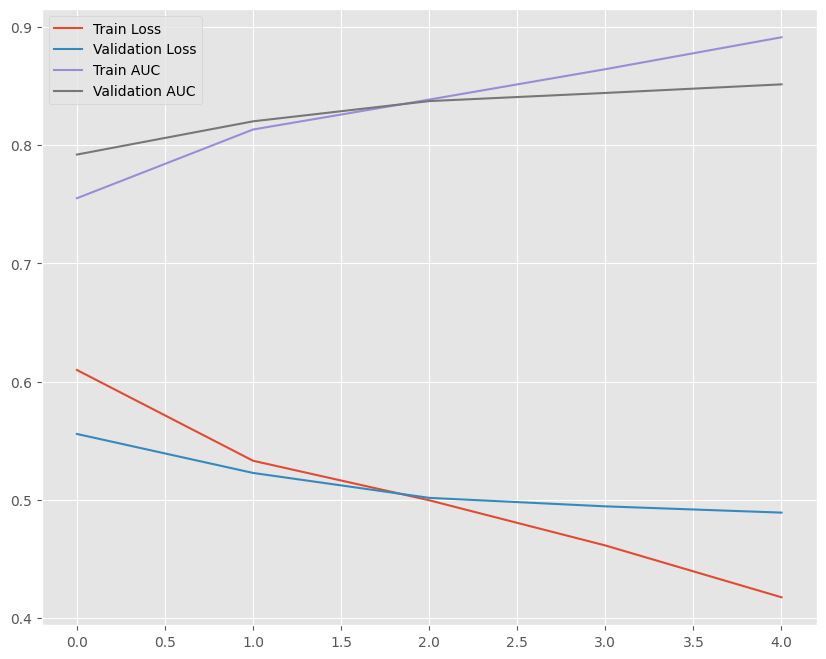

Validation AUC: 0.8447


In [14]:
loss = pd.DataFrame.from_dict(history.history)
display(loss.head())

plt.figure(figsize=(10,8))
plt.plot(loss['loss'], label='Train Loss')
plt.plot(loss['val_loss'], label='Validation Loss')

# Plot AUC 
plt.plot(loss['auc'], label='Train AUC')
plt.plot(loss['val_auc'], label='Validation AUC')

plt.legend()
plt.show()

# Evaluate the model on the validation dataset
val_metrics = model.evaluate(ds_valid.batch(BATCH_SIZE), verbose=0)

val_auc_index = model.metrics_names.index('auc')
auc_score_baseline1 = val_metrics[val_auc_index]

print(f"Validation AUC: {auc_score_baseline1:.4f}")

In [15]:
import numpy as np

def add_noise_to_weights(weights, noise_std=0.01):
    """Adds Gaussian noise to a dictionary of weights."""
    noisy_weights = {}
    for key, weight in weights.items():
        # Generating Gaussian noise with the same shape as the weight
        noise = np.random.normal(loc=0.0, scale=noise_std, size=weight.shape)
        # Adding the noise to the weight
        noisy_weight = weight + noise
        noisy_weights[key] = noisy_weight
    return noisy_weights

# Extract the model's weights into a dictionary
model_weights_dict_1 = {v.name: v.numpy() for v in model.trainable_variables}

# Add noise to the model's weights
noisy_model_weights_dict_1 = add_noise_to_weights(model_weights_dict_1, noise_std=0.01)

# Now, noisy_model_weights_dict contains the weights with added Gaussian noise

In [28]:
node = sy.orchestra.launch(name="test-domain-1", port="auto", dev_mode=True, reset=True)

Staging Protocol Changes...
Starting test-domain-1 server on 0.0.0.0:53466


kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /Users/alex


Waiting for server to start....

INFO:     Started server process [47496]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:53466 (Press CTRL+C to quit)


.
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/7bca415d13ed4ec881f0d0aede098dbb.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=0 image_uid=4924278ddf9741e2ac448bbe7007374e in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
INFO:     127.0.0.1:60144 - "GET /api/v2/metadata HTTP/1.1" 200 OK
 Done.


Login to the Domain

In [29]:
domain_client = node.login(email="info@openmined.org", password="changethis")

INFO:     127.0.0.1:60146 - "GET /api/v2/metadata HTTP/1.1" 200 OK
INFO:     127.0.0.1:60146 - "GET /api/v2/metadata HTTP/1.1" 200 OK
Logged into <test-domain-1: High-side Domain> as GUEST
INFO:     127.0.0.1:60146 - "POST /api/v2/login HTTP/1.1" 200 OK
INFO:     127.0.0.1:60146 - "GET /api/v2/api?verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f&communication_protocol=3 HTTP/1.1" 200 OK
INFO:     127.0.0.1:60148 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Logged into <test-domain-1: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

Initialize Model Weights

In [30]:
# Convert the trained model parameters to a Syft ActionObject
model_weights_obj = sy.ActionObject.from_obj(noisy_model_weights_dict_1)

# Check the object type and attributes
print(type(model_weights_obj.syft_action_data), model_weights_obj.id)


<class 'dict'> 83f75f71f93548e78c8d53c5c540a095


In [31]:
# Set the model weights ActionObject in the domain
weight_domain_obj = domain_client.api.services.action.set(model_weights_obj)

# Check the domain object attributes
print(weight_domain_obj.id)


INFO:     127.0.0.1:60150 - "POST /api/v2/api_call HTTP/1.1" 200 OK
83f75f71f93548e78c8d53c5c540a095


Convert Model Weights to Syft ActionObject:

Define a Weights Access function

In [32]:
@sy.syft_function(
    input_policy=sy.ExactMatch(weights=weight_domain_obj.id),
    output_policy=sy.SingleExecutionExactOutput(),
)
def fetch_weights(weights):
    # Simply return the weights; no computation needed
    return weights


INFO:     127.0.0.1:60152 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:60146 - "GET /api/v2/metadata HTTP/1.1" 200 OK


SyftSuccess: Syft function 'fetch_weights' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

Access Weights

In [33]:
weights_pointer = fetch_weights(weights=weight_domain_obj)
weights_local = weights_pointer.get()

SyftInfo: Creating a node with n_consumers=2 (the default value)
Staging Protocol Changes...
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/440aa005431548a3851d05e1c47a8023.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=2 image_uid=530f359ce5f6417d99df4effa1278c9f in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
Logged into <ephemeral_node_fetch_weights_2619: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

INFO:     127.0.0.1:60160 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:60162 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain ephemeral_node_fetch_weights_2619
SyftInfo: Landing the ephmeral node...
SyftInfo: Node Landed!


Retrieve and Verify the Output

Request and Approve Code Execution

In [34]:
request = domain_client.code.request_code_execution(fetch_weights)
request

INFO:     127.0.0.1:60165 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:60167 - "GET /api/v2/api?verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f&communication_protocol=3 HTTP/1.1" 200 OK
INFO:     127.0.0.1:60172 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:60174 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:60176 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:60178 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:60180 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:60182 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:60184 - "POST /api/v2/api_call HTTP/1.1" 200 OK


syft.service.request.request.Request

In [35]:
request.approve()

INFO:     127.0.0.1:60167 - "GET /api/v2/metadata HTTP/1.1" 200 OK
INFO:     127.0.0.1:60186 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:60188 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:60190 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:60192 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:60194 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:60196 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:60198 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain test-domain-1
INFO:     127.0.0.1:60200 - "POST /api/v2/api_call HTTP/1.1" 200 OK


SyftSuccess: Request f95bc34bc4094d0382170b1d199a2343 changes applied

In [36]:
domain_client._api = None
_ = domain_client.api

INFO:     127.0.0.1:60167 - "GET /api/v2/api?verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f&communication_protocol=3 HTTP/1.1" 200 OK


Fetching the pointer and the actual weights

In [37]:
# Fetch the weights pointer from the domain
weights_ptr = fetch_weights(weights=weight_domain_obj)

# Retrieve the actual weights from the pointer
weights_local = weights_ptr.get()


SyftInfo: Creating a node with n_consumers=2 (the default value)
Staging Protocol Changes...
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/cac611cc89044983a02bde24419f35e2.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=2 image_uid=77812f4083e648fa9895b4700778308e in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
Logged into <ephemeral_node_fetch_weights_4339: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

INFO:     127.0.0.1:60206 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:60208 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain ephemeral_node_fetch_weights_4339
SyftInfo: Landing the ephmeral node...
SyftInfo: Node Landed!


Retrieving the Computation Result

Cleanup and Land the Node

In [38]:
if node.node_type.value == "python":
    node.land()

## Data Owner 2

In [39]:
tf.keras.backend.clear_session() #clears keras session to have the same mapping for DO1 and DO2 dictionaries

TRAIN_SPLIT = 0.8
VALIDATION_SPLIT = 0.2

# Dataset size
dataset_size = len(df2)
train_size = int(dataset_size * TRAIN_SPLIT)
test_size = dataset_size - train_size
validation_size = int(test_size * VALIDATION_SPLIT)

# Creating the dataset
ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices((
        tf.cast(df2[dense_cols].values, tf.float32),
        tf.cast(df2[cat_cols].values, tf.int32),
    )),
    tf.data.Dataset.from_tensor_slices(tf.cast(to_categorical(df2['label'].values, num_classes=2), tf.float32))
)).shuffle(buffer_size=2048)

# Splitting the dataset
ds_train = ds.take(train_size)
ds_test = ds.skip(train_size)
ds_valid = ds_test.take(validation_size)
ds_test = ds_test.skip(validation_size)

In [40]:
def MLP(arch, activation='relu', out_activation=None):
    mlp = tf.keras.Sequential()

    for units in arch[:-1]:
        mlp.add(tf.keras.layers.Dense(units, activation=activation))

    mlp.add(tf.keras.layers.Dense(arch[-1], activation=out_activation))

    return mlp


class SecondOrderFeatureInteraction(tf.keras.layers.Layer):
    def __init__(self, self_interaction=False):
        super(SecondOrderFeatureInteraction, self).__init__()
        self.self_interaction = self_interaction

    def call(self, inputs):
        batch_size = tf.shape(inputs[0])[0]
        concat_features = tf.stack(inputs, axis=1)

        dot_products = tf.matmul(concat_features, concat_features, transpose_b=True)

        ones = tf.ones_like(dot_products)
        mask = tf.linalg.band_part(ones, 0, -1)
        out_dim = int(len(inputs) * (len(inputs) + 1) / 2)

        if not self.self_interaction:
            mask = mask - tf.linalg.band_part(ones, 0, 0)
            out_dim = int(len(inputs) * (len(inputs) - 1) / 2)

        flat_interactions = tf.reshape(tf.boolean_mask(dot_products, mask), (batch_size, out_dim))
        return flat_interactions


class DLRM(tf.keras.Model):
    def __init__(
            self,
            embedding_sizes,
            embedding_dim,
            arch_bot,
            arch_top,
            self_interaction,
    ):
        super(DLRM, self).__init__()
        self.emb = [tf.keras.layers.Embedding(size, embedding_dim) for size in embedding_sizes]
        self.bot_nn = MLP(arch_bot, out_activation='relu')
        self.top_nn = MLP(arch_top, out_activation='sigmoid')
        self.interaction_op = SecondOrderFeatureInteraction(self_interaction)

    def call(self, input):
        input_dense, input_cat = input
        emb_x = [E(x) for E, x in zip(self.emb, tf.unstack(input_cat, axis=1))]
        dense_x = self.bot_nn(input_dense)

        Z = self.interaction_op(emb_x + [dense_x])
        z = tf.concat([dense_x, Z], axis=1)
        p = self.top_nn(z)

        return p

In [41]:
model = DLRM(
    embedding_sizes=emb_counts,
    embedding_dim=2,
    arch_bot=[8, 2],
    arch_top=[128, 64, 2],
    self_interaction=False
)

model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy', AUC(name='auc')]  
)

In [42]:
BATCH_SIZE = 128

history =model.fit(
    ds_train.batch(BATCH_SIZE),
    validation_data=ds_valid.batch(BATCH_SIZE),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
    ],
    epochs=5,
    verbose=1,
)


Epoch 1/5
427/427 [==============================] - 7s 12ms/step - loss: 0.6050 - accuracy: 0.7465 - auc: 0.7577 - val_loss: 0.5506 - val_accuracy: 0.7516 - val_auc: 0.7948
Epoch 2/5
427/427 [==============================] - 5s 12ms/step - loss: 0.5357 - accuracy: 0.7490 - auc: 0.8158 - val_loss: 0.5165 - val_accuracy: 0.7523 - val_auc: 0.8280
Epoch 3/5
427/427 [==============================] - 6s 14ms/step - loss: 0.4916 - accuracy: 0.7636 - auc: 0.8440 - val_loss: 0.4984 - val_accuracy: 0.7673 - val_auc: 0.8379
Epoch 4/5
427/427 [==============================] - 7s 17ms/step - loss: 0.4518 - accuracy: 0.7910 - auc: 0.8706 - val_loss: 0.4782 - val_accuracy: 0.7746 - val_auc: 0.8542
Epoch 5/5
427/427 [==============================] - 6s 15ms/step - loss: 0.4092 - accuracy: 0.8173 - auc: 0.8959 - val_loss: 0.4841 - val_accuracy: 0.7761 - val_auc: 0.8545


In [43]:
model.summary()

Model: "dlrm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  1204      
                                                                 
 embedding_1 (Embedding)     multiple                  1022      
                                                                 
 embedding_2 (Embedding)     multiple                  114322    
                                                                 
 embedding_3 (Embedding)     multiple                  59116     
                                                                 
 embedding_4 (Embedding)     multiple                  330       
                                                                 
 embedding_5 (Embedding)     multiple                  26        
                                                                 
 embedding_6 (Embedding)     multiple                  16824  

In [44]:
results = model.evaluate(ds_test.batch(BATCH_SIZE))
print(f'Loss: {results[0]}, Accuracy: {results[1]}, AUC: {results[2]}')

86/86 [==============================] - 1s 5ms/step - loss: 0.5290 - accuracy: 0.7481 - auc: 0.8278
Loss: 0.5290026664733887, Accuracy: 0.7481454610824585, AUC: 0.8278278708457947


,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.605008,0.746538,0.757665,0.550623,0.751557,0.794797
1,0.535727,0.748956,0.815751,0.516547,0.752290,0.828008
2,0.491603,0.763629,0.843981,0.498378,0.767314,0.837905
3,0.451783,0.790980,0.870584,0.478167,0.774643,0.854219
4,0.409159,0.817286,0.895889,0.484144,0.776108,0.854519


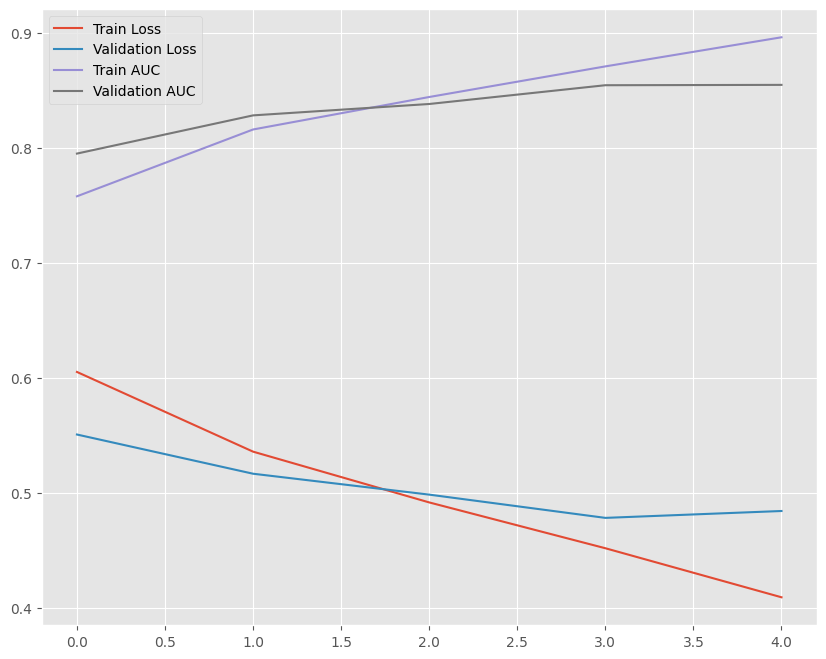

Validation AUC: 0.8566


In [45]:
loss = pd.DataFrame.from_dict(history.history)
display(loss.head())

plt.figure(figsize=(10,8))
plt.plot(loss['loss'], label='Train Loss')
plt.plot(loss['val_loss'], label='Validation Loss')

# Plot AUC 
plt.plot(loss['auc'], label='Train AUC')
plt.plot(loss['val_auc'], label='Validation AUC')

plt.legend()
plt.show()

# Evaluate the model on the validation dataset
val_metrics = model.evaluate(ds_valid.batch(BATCH_SIZE), verbose=0)

val_auc_index = model.metrics_names.index('auc')
auc_score_baseline2 = val_metrics[val_auc_index]

print(f"Validation AUC: {auc_score_baseline2:.4f}")

In [46]:
import numpy as np

def add_noise_to_weights(weights, noise_std=0.01):
    """Adds Gaussian noise to a dictionary of weights."""
    noisy_weights = {}
    for key, weight in weights.items():
        # Generating Gaussian noise with the same shape as the weight
        noise = np.random.normal(loc=0.0, scale=noise_std, size=weight.shape)
        # Adding the noise to the weight
        noisy_weight = weight + noise
        noisy_weights[key] = noisy_weight
    return noisy_weights

# Extract the model's weights into a dictionary
model_weights_dict_2 = {v.name: v.numpy() for v in model.trainable_variables}

# Add noise to the model's weights
noisy_model_weights_dict_2 = add_noise_to_weights(model_weights_dict_2, noise_std=0.01)

# Now, noisy_model_weights_dict contains the weights with added Gaussian noise

In [47]:
node_2 = sy.orchestra.launch(name="test-domain-2", port="auto", dev_mode=True, reset=True)

Staging Protocol Changes...
Starting test-domain-2 server on 0.0.0.0:13859


python(47526) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /Users/alex


Waiting for server to start......

INFO:     Started server process [47526]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:13859 (Press CTRL+C to quit)


. Done.
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/b626124c319343c882a448dac2d6953d.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=0 image_uid=8def1d1bfce94abea50c1224587e31d3 in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
INFO:     127.0.0.1:60244 - "GET /api/v2/metadata HTTP/1.1" 200 OK



Login to the Domain

In [48]:
domain_client_2 = node_2.login(email="info@openmined.org", password="changethis")

INFO:     127.0.0.1:60246 - "GET /api/v2/metadata HTTP/1.1" 200 OK
INFO:     127.0.0.1:60246 - "GET /api/v2/metadata HTTP/1.1" 200 OK
Logged into <test-domain-2: High-side Domain> as GUEST
INFO:     127.0.0.1:60246 - "POST /api/v2/login HTTP/1.1" 200 OK
INFO:     127.0.0.1:60246 - "GET /api/v2/api?verify_key=0dfade1de62080fb5e584e38a1b82ca623859caaefd6f13ae821a4e5172df446&communication_protocol=3 HTTP/1.1" 200 OK
INFO:     127.0.0.1:60248 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Logged into <test-domain-2: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

Initialize Model Weights

In [49]:
# Convert the trained model parameters to a Syft ActionObject
model_weights_obj = sy.ActionObject.from_obj(noisy_model_weights_dict_2)

# Check the object type and attributes
print(type(model_weights_obj.syft_action_data), model_weights_obj.id)


<class 'dict'> 8acdd051571147e7b166385f0d8a459d


In [50]:
# Set the model weights ActionObject in the domain
weight_domain_obj = domain_client_2.api.services.action.set(model_weights_obj)

# Check the domain object attributes
print(weight_domain_obj.id)


INFO:     127.0.0.1:60251 - "POST /api/v2/api_call HTTP/1.1" 200 OK
8acdd051571147e7b166385f0d8a459d


Convert Model Weights to Syft ActionObject:

Define a Weights Access function

In [51]:
@sy.syft_function(
    input_policy=sy.ExactMatch(weights=weight_domain_obj.id),
    output_policy=sy.SingleExecutionExactOutput(),
)
def fetch_weights(weights):
    # Simply return the weights; no computation needed
    return weights


INFO:     127.0.0.1:60253 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:60255 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:60246 - "GET /api/v2/metadata HTTP/1.1" 200 OK


SyftSuccess: Syft function 'fetch_weights' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

Access Weights

In [52]:
weights_pointer = fetch_weights(weights=weight_domain_obj)
weights_local_2 = weights_pointer.get()

SyftInfo: Creating a node with n_consumers=2 (the default value)
Staging Protocol Changes...
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/aac26dcd4fab4d939dc142deef5ea4e7.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=2 image_uid=a7b2c81bb76b4c7b8978360432ae9d16 in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
Logged into <ephemeral_node_fetch_weights_932: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

INFO:     127.0.0.1:60263 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:60265 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain ephemeral_node_fetch_weights_932
SyftInfo: Landing the ephmeral node...
SyftInfo: Node Landed!


Retrieve and Verify the Output

Request and Approve Code Execution

In [53]:
request = domain_client_2.code.request_code_execution(fetch_weights)
request

INFO:     127.0.0.1:60267 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:60269 - "GET /api/v2/api?verify_key=0dfade1de62080fb5e584e38a1b82ca623859caaefd6f13ae821a4e5172df446&communication_protocol=3 HTTP/1.1" 200 OK
INFO:     127.0.0.1:60272 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:60274 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:60276 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:60278 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:60280 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:60282 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:60284 - "POST /api/v2/api_call HTTP/1.1" 200 OK


syft.service.request.request.Request

In [54]:
request.approve()

INFO:     127.0.0.1:60269 - "GET /api/v2/metadata HTTP/1.1" 200 OK
INFO:     127.0.0.1:60286 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:60288 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:60290 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:60292 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:60294 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:60296 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:60298 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain test-domain-2
INFO:     127.0.0.1:60300 - "POST /api/v2/api_call HTTP/1.1" 200 OK


SyftSuccess: Request 727468c4d30247178e10aa94b877c454 changes applied

In [55]:
domain_client_2._api = None
_ = domain_client_2.api

INFO:     127.0.0.1:60269 - "GET /api/v2/api?verify_key=0dfade1de62080fb5e584e38a1b82ca623859caaefd6f13ae821a4e5172df446&communication_protocol=3 HTTP/1.1" 200 OK


Fetching the pointer and the actual weights

In [56]:
# Fetch the weights pointer from the domain
weights_ptr = fetch_weights(weights=weight_domain_obj)

# Retrieve the actual weights from the pointer
weights_local_2 = weights_ptr.get()


SyftInfo: Creating a node with n_consumers=2 (the default value)
Staging Protocol Changes...
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/d42c2f6df4b743599ca5bf86429ad1c7.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=2 image_uid=842e44dee27d407c9574293a537f2272 in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
Logged into <ephemeral_node_fetch_weights_6861: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

INFO:     127.0.0.1:60308 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:60310 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain ephemeral_node_fetch_weights_6861
SyftInfo: Landing the ephmeral node...
SyftInfo: Node Landed!


Retrieving the Computation Result

Cleanup and Land the Node

In [57]:
if node_2.node_type.value == "python":
    node_2.land()

## Data Scientist

In [58]:
weights1 = weights_local
weights2 = weights_local_2

In [59]:
import jax.numpy as jnp

def combine_weights(weights1, weights2):
    """Combines two sets of weights by averaging."""
    global_weights = {}
    
    # Ensure the keys in both weight sets are identical
    assert set(weights1.keys()) == set(weights2.keys()), "Weight sets have different structures"
    
    # Iterate through each layer's weights
    for key in weights1:
        layer_weights1 = weights1[key]
        layer_weights2 = weights2[key]
        
        # Ensure each layer's weights have identical shapes
        assert layer_weights1.shape == layer_weights2.shape, f"Layer {key} has different shapes"
        
        # Average the weights
        global_weights[key] = (layer_weights1 + layer_weights2) / 2
    
    return global_weights


In [60]:
global_weights = combine_weights(weights1, weights_local_2)

# Data Owner 1 with Global Model Weights 

In [61]:
import jax.numpy as jnp

def combine_weights(weights1, global_weights, alpha=0.5):
    """Combines two sets of weights by averaging."""
    global_weights_mix_1 = {}
    
    # Ensure the keys in both weight sets are identical
    assert set(weights1.keys()) == set(global_weights.keys()), "Weight sets have different structures"
    
    # Iterate through each layer's weights
    for key in weights1:
        layer_weights1 = weights1[key]
        layer_global_weights = global_weights[key]
        
        # Ensure each layer's weights have identical shapes
        assert layer_weights1.shape == layer_global_weights.shape, f"Layer {key} has different shapes"
        
        # Average the weights
        global_weights_mix_1[key] = (alpha * layer_weights1 + (1- alpha) * layer_global_weights)
    
    return global_weights_mix_1


In [62]:
global_weights_mix_1 = combine_weights(weights_local, global_weights)

In [63]:
tf.keras.backend.clear_session() #clears keras session to have the same mapping for DO1 and DO2 dictionaries

TRAIN_SPLIT = 0.8
VALIDATION_SPLIT = 0.2

# Dataset size
dataset_size = len(df1)
train_size = int(dataset_size * TRAIN_SPLIT)
test_size = dataset_size - train_size
validation_size = int(test_size * VALIDATION_SPLIT)

# Creating the dataset
ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices((
        tf.cast(df1[dense_cols].values, tf.float32),
        tf.cast(df1[cat_cols].values, tf.int32),
    )),
    tf.data.Dataset.from_tensor_slices(tf.cast(to_categorical(df1['label'].values, num_classes=2), tf.float32))
)).shuffle(buffer_size=2048)

# Splitting the dataset
ds_train = ds.take(train_size)
ds_test = ds.skip(train_size)
ds_valid = ds_test.take(validation_size)
ds_test = ds_test.skip(validation_size)

In [64]:
embedding_sizes = [emb_count for emb_count in emb_counts]

# Model architecture parameters
embedding_dim = 2
arch_bot = [8, 2]  # Architecture for the bottom MLP (processing dense features)
arch_top = [128, 64, 2]  # Architecture for the top MLP (combining embeddings and processed dense features)

class DLRM(tf.keras.Model):
    def __init__(self, embedding_sizes, embedding_dim, arch_bot, arch_top, self_interaction):
        super(DLRM, self).__init__()
        self.emb = [tf.keras.layers.Embedding(size, embedding_dim) for size in embedding_sizes]
        self.bot_nn = MLP(arch_bot, out_activation='relu')
        self.top_nn = MLP(arch_top, out_activation='sigmoid')
        self.interaction_op = SecondOrderFeatureInteraction(self_interaction)

    def call(self, inputs):
        input_dense, input_cat = inputs
        emb_x = [E(x) for E, x in zip(self.emb, tf.unstack(input_cat, axis=1))]
        dense_x = self.bot_nn(input_dense)

        Z = self.interaction_op(emb_x + [dense_x])
        z = tf.concat([dense_x, Z], axis=1)
        p = self.top_nn(z)

        return p

# Initialize the model
model = DLRM(
    embedding_sizes=embedding_sizes,
    embedding_dim=embedding_dim,
    arch_bot=arch_bot,
    arch_top=arch_top,
    self_interaction=False
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy', AUC(name='auc')]
)

# Generate dummy input to build the model
dummy_input_dense = tf.random.uniform((1, len(dense_cols)), dtype=tf.float32)
dummy_input_cat = tf.random.uniform((1, len(cat_cols)), maxval=2, dtype=tf.int32)
model([dummy_input_dense, dummy_input_cat])  # This builds the model's layers

# Set the pre-trained weights
for layer in model.layers:
    if hasattr(layer, 'layers'):  # For nested layers
        for sub_layer in layer.layers:
            if sub_layer.name in global_weights_mix_1:
                sub_layer.set_weights(global_weights_mix_1[sub_layer.name])
    else:
        if layer.name in global_weights_mix_1:
            layer.set_weights(global_weights_mix_1[layer.name])


In [65]:
BATCH_SIZE = 128

history =model.fit(
    ds_train.batch(BATCH_SIZE),
    validation_data=ds_valid.batch(BATCH_SIZE),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
    ],
    epochs=5,
    verbose=1,
)


Epoch 1/5
427/427 [==============================] - 6s 9ms/step - loss: 0.5950 - accuracy: 0.7476 - auc: 0.7592 - val_loss: 0.5794 - val_accuracy: 0.7226 - val_auc: 0.7657
Epoch 2/5
427/427 [==============================] - 4s 10ms/step - loss: 0.5401 - accuracy: 0.7482 - auc: 0.8059 - val_loss: 0.5334 - val_accuracy: 0.7483 - val_auc: 0.8114
Epoch 3/5
427/427 [==============================] - 4s 10ms/step - loss: 0.5058 - accuracy: 0.7569 - auc: 0.8340 - val_loss: 0.4955 - val_accuracy: 0.7706 - val_auc: 0.8418
Epoch 4/5
427/427 [==============================] - 3s 6ms/step - loss: 0.4658 - accuracy: 0.7800 - auc: 0.8614 - val_loss: 0.4819 - val_accuracy: 0.7805 - val_auc: 0.8522
Epoch 5/5
427/427 [==============================] - 6s 14ms/step - loss: 0.4235 - accuracy: 0.8078 - auc: 0.8879 - val_loss: 0.4852 - val_accuracy: 0.7820 - val_auc: 0.8520


In [66]:
model.summary()

Model: "dlrm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  1204      
                                                                 
 embedding_1 (Embedding)     multiple                  1022      
                                                                 
 embedding_2 (Embedding)     multiple                  114322    
                                                                 
 embedding_3 (Embedding)     multiple                  59116     
                                                                 
 embedding_4 (Embedding)     multiple                  330       
                                                                 
 embedding_5 (Embedding)     multiple                  26        
                                                                 
 embedding_6 (Embedding)     multiple                  16824  

In [67]:
results = model.evaluate(ds_test.batch(BATCH_SIZE))
print(f'Loss: {results[0]}, Accuracy: {results[1]}, AUC: {results[2]}')

86/86 [==============================] - 1s 4ms/step - loss: 0.5294 - accuracy: 0.7472 - auc: 0.8233
Loss: 0.529424786567688, Accuracy: 0.7472295761108398, AUC: 0.8232953548431396


,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.594954,0.747564,0.759219,0.579448,0.722609,0.765734
1,0.540116,0.748168,0.805870,0.533357,0.748259,0.811442
2,0.505840,0.756888,0.833963,0.495479,0.770612,0.841820
3,0.465841,0.780025,0.861399,0.481865,0.780506,0.852173
4,0.423491,0.807833,0.887914,0.485247,0.781971,0.852004


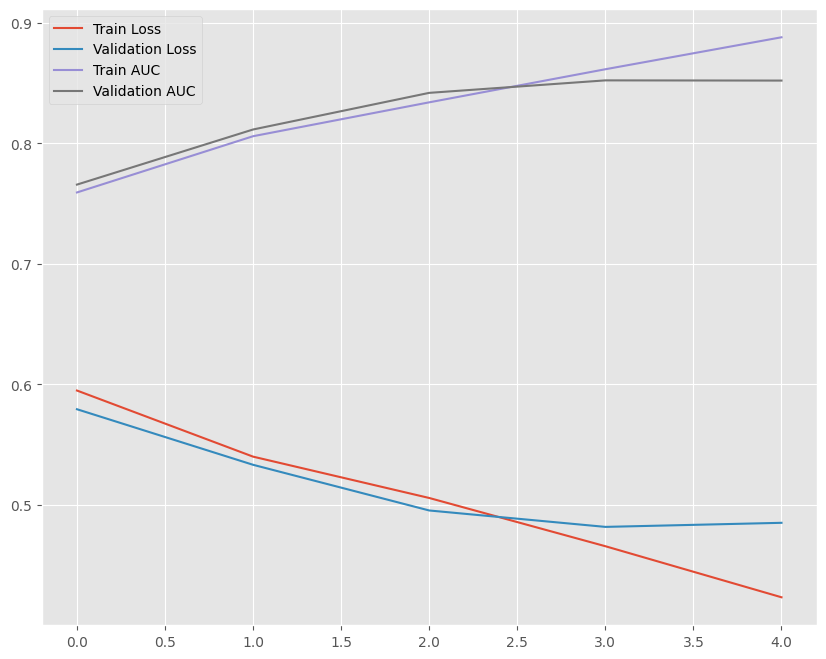

In [68]:
loss = pd.DataFrame.from_dict(history.history)
display(loss.head())

plt.figure(figsize=(10,8))
plt.plot(loss['loss'], label='Train Loss')
plt.plot(loss['val_loss'], label='Validation Loss')

# Plot AUC
plt.plot(loss['auc'], label='Train AUC')
plt.plot(loss['val_auc'], label='Validation AUC')

plt.legend()
plt.show()


In [69]:
# Evaluate the model on the validation dataset
val_metrics = model.evaluate(ds_valid.batch(BATCH_SIZE), verbose=0)
val_auc_index = model.metrics_names.index('auc')
val_auc = val_metrics[val_auc_index]

print(f"Validation AUC: {val_auc:.4f}")

Validation AUC: 0.8531


In [70]:
rela_impr = ((val_auc - 0.5) / (auc_score_baseline1 - 0.5)) * 100
print(f"Relative Improvement (RelaImpr): {rela_impr:.2f}%")

Relative Improvement (RelaImpr): 102.44%


# Data Owner 2 with Global Model Weights 

In [71]:
import jax.numpy as jnp

def combine_weights(weights2, global_weights, alpha=0.5): #alpha to determine the mix between global and local weights
    """Combines two sets of weights by averaging."""
    global_weights_mix_2 = {}
    
    # Ensure the keys in both weight sets are identical
    assert set(weights2.keys()) == set(global_weights.keys()), "Weight sets have different structures"
    
    # Iterate through each layer's weights
    for key in weights2:
        layer_weights2 = weights2[key]
        layer_global_weights = global_weights[key]
        
        # Ensure each layer's weights have identical shapes
        assert layer_weights2.shape == layer_global_weights.shape, f"Layer {key} has different shapes"
        
        # Average the weights
        global_weights_mix_2[key] = (alpha * layer_weights2 + (1- alpha) * layer_global_weights)
    
    return global_weights_mix_2


In [72]:
global_weights_mix_2 = combine_weights(weights2, global_weights)

In [73]:
tf.keras.backend.clear_session() #clears keras session to have the same mapping for DO1 and DO2 dictionaries

TRAIN_SPLIT = 0.8
VALIDATION_SPLIT = 0.2

# Dataset size
dataset_size = len(df2)
train_size = int(dataset_size * TRAIN_SPLIT)
test_size = dataset_size - train_size
validation_size = int(test_size * VALIDATION_SPLIT)

# Creating the dataset
ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices((
        tf.cast(df2[dense_cols].values, tf.float32),
        tf.cast(df2[cat_cols].values, tf.int32),
    )),
    tf.data.Dataset.from_tensor_slices(tf.cast(to_categorical(df2['label'].values, num_classes=2), tf.float32))
)).shuffle(buffer_size=2048)

# Splitting the dataset
ds_train = ds.take(train_size)
ds_test = ds.skip(train_size)
ds_valid = ds_test.take(validation_size)
ds_test = ds_test.skip(validation_size)

In [74]:
embedding_sizes = [emb_count for emb_count in emb_counts]

# Model architecture parameters
embedding_dim = 2
arch_bot = [8, 2]  # Architecture for the bottom MLP (processing dense features)
arch_top = [128, 64, 2]  # Architecture for the top MLP (combining embeddings and processed dense features)

class DLRM(tf.keras.Model):
    def __init__(self, embedding_sizes, embedding_dim, arch_bot, arch_top, self_interaction):
        super(DLRM, self).__init__()
        self.emb = [tf.keras.layers.Embedding(size, embedding_dim) for size in embedding_sizes]
        self.bot_nn = MLP(arch_bot, out_activation='relu')
        self.top_nn = MLP(arch_top, out_activation='sigmoid')
        self.interaction_op = SecondOrderFeatureInteraction(self_interaction)

    def call(self, inputs):
        input_dense, input_cat = inputs
        emb_x = [E(x) for E, x in zip(self.emb, tf.unstack(input_cat, axis=1))]
        dense_x = self.bot_nn(input_dense)

        Z = self.interaction_op(emb_x + [dense_x])
        z = tf.concat([dense_x, Z], axis=1)
        p = self.top_nn(z)

        return p

# Initialize the model
model = DLRM(
    embedding_sizes=embedding_sizes,
    embedding_dim=embedding_dim,
    arch_bot=arch_bot,
    arch_top=arch_top,
    self_interaction=False
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy', AUC(name='auc')]
)

# Generate dummy input to build the model
dummy_input_dense = tf.random.uniform((1, len(dense_cols)), dtype=tf.float32)
dummy_input_cat = tf.random.uniform((1, len(cat_cols)), maxval=2, dtype=tf.int32)
model([dummy_input_dense, dummy_input_cat])  # This builds the model's layers

# Set the pre-trained weights
for layer in model.layers:
    if hasattr(layer, 'layers'):  # For nested layers
        for sub_layer in layer.layers:
            if sub_layer.name in global_weights_mix_2:
                sub_layer.set_weights(global_weights_mix_2[sub_layer.name])
    else:
        if layer.name in global_weights_mix_2:
            layer.set_weights(global_weights_mix_2[layer.name])


In [75]:
BATCH_SIZE = 128

history =model.fit(
    ds_train.batch(BATCH_SIZE),
    validation_data=ds_valid.batch(BATCH_SIZE),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
    ],
    epochs=5,
    verbose=1,
)


Epoch 1/5
427/427 [==============================] - 9s 15ms/step - loss: 0.6079 - accuracy: 0.7497 - auc: 0.7518 - val_loss: 0.5602 - val_accuracy: 0.7453 - val_auc: 0.7856
Epoch 2/5
427/427 [==============================] - 6s 13ms/step - loss: 0.5411 - accuracy: 0.7491 - auc: 0.8118 - val_loss: 0.5319 - val_accuracy: 0.7435 - val_auc: 0.8161
Epoch 3/5
427/427 [==============================] - 6s 14ms/step - loss: 0.4969 - accuracy: 0.7623 - auc: 0.8402 - val_loss: 0.4922 - val_accuracy: 0.7699 - val_auc: 0.8417
Epoch 4/5
427/427 [==============================] - 6s 14ms/step - loss: 0.4566 - accuracy: 0.7868 - auc: 0.8672 - val_loss: 0.4708 - val_accuracy: 0.7820 - val_auc: 0.8574
Epoch 5/5
427/427 [==============================] - 6s 13ms/step - loss: 0.4143 - accuracy: 0.8138 - auc: 0.8928 - val_loss: 0.4810 - val_accuracy: 0.7831 - val_auc: 0.8538


In [76]:
model.summary()

Model: "dlrm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  1204      
                                                                 
 embedding_1 (Embedding)     multiple                  1022      
                                                                 
 embedding_2 (Embedding)     multiple                  114322    
                                                                 
 embedding_3 (Embedding)     multiple                  59116     
                                                                 
 embedding_4 (Embedding)     multiple                  330       
                                                                 
 embedding_5 (Embedding)     multiple                  26        
                                                                 
 embedding_6 (Embedding)     multiple                  16824  

In [77]:
results = model.evaluate(ds_test.batch(BATCH_SIZE))
print(f'Loss: {results[0]}, Accuracy: {results[1]}, AUC: {results[2]}')

86/86 [==============================] - 1s 4ms/step - loss: 0.5443 - accuracy: 0.7410 - auc: 0.8159
Loss: 0.5442898869514465, Accuracy: 0.7410019040107727, AUC: 0.8158567547798157


,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.607873,0.749670,0.751798,0.560203,0.745328,0.785612
1,0.541095,0.749139,0.811798,0.531862,0.743496,0.816119
2,0.496895,0.762329,0.840186,0.492212,0.769879,0.841676
3,0.456567,0.786766,0.867220,0.470814,0.781971,0.857364
4,0.414330,0.813787,0.892778,0.480978,0.783071,0.853769


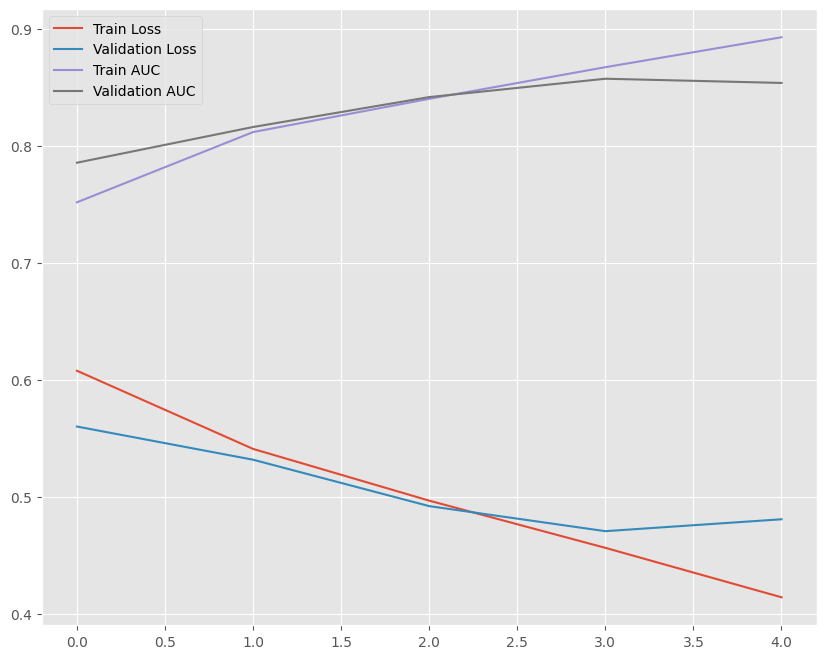

In [78]:
loss = pd.DataFrame.from_dict(history.history)
display(loss.head())

plt.figure(figsize=(10,8))
plt.plot(loss['loss'], label='Train Loss')
plt.plot(loss['val_loss'], label='Validation Loss')

# Plot AUC
plt.plot(loss['auc'], label='Train AUC')
plt.plot(loss['val_auc'], label='Validation AUC')

plt.legend()
plt.show()


In [79]:
# Evaluate the model on the validation dataset
val_metrics = model.evaluate(ds_valid.batch(BATCH_SIZE), verbose=0)
val_auc_index = model.metrics_names.index('auc')
val_auc = val_metrics[val_auc_index]

print(f"Validation AUC: {val_auc:.4f}")


Validation AUC: 0.8532


In [80]:
rela_impr = ((val_auc - 0.5) / (auc_score_baseline2 - 0.5)) * 100
print(f"Relative Improvement (RelaImpr): {rela_impr:.2f}%")

Relative Improvement (RelaImpr): 99.06%
